In [1]:
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options
import numpy as np
import sys
import gamspy as gp
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt


In [6]:

tickers = [
    # Integrated Oil & Gas
    "XOM", "CVX", "BP", "SHEL", "TTE", "E", "PBR", "EQNR",

    # Exploration & Production
    "COP", "MRO", "DVN", "EOG", "APA", "AR", "OXY",

    # Oilfield Services
    "SLB", "HAL", "BKR", "NBR", "FTI",

    # Midstream & Pipelines
    "EPD", "ENB", "KMI", "WMB", "OKE", "TRP",

    # Refining & Marketing
    "PSX", "VLO", "MPC", "DK",

    # Renewable Energy
    "NEE", "BEPC", "AY", "CWEN", "PLUG", "FSLR", "RUN", "ENPH",

    # Utilities (Energy Focus)
    "DUK", "SO", "AEP", "D", "EXC"
]

# Fetch historical stock data for the past year
data = yf.download(tickers, start="2023-10-31", end="2024-10-31")["Adj Close"]

# Resample to monthly data (mid-market prices at the last trading day of each month)
monthly_data = data.resample('M').last()

# Ensure we get exactly the last 12 months
monthly_data = monthly_data.tail(12)

# Convert to NumPy array (12 rows for months, 30 columns for stocks)
prices_array = monthly_data.to_numpy()

# Transpose to get 30 rows (stocks) and 12 columns (months)
prices_array = prices_array.T

# Check the shape for verification
print("Shape:", prices_array.shape)  # Should be (30, 12)



stock_index = prices_array.shape[0]

[*********************100%***********************]  43 of 43 completed

1 Failed download:
['MRO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Shape: (43, 12)


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_16968\37950997.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').last()


In [12]:
# Reweight prices to start at 1 for each stock
# Divide each row by the first column value
prices_array_reweighted = prices_array / prices_array[:, 0][:, np.newaxis]

# Round to 5 significant figures
prices_array_reweighted = np.round(prices_array_reweighted, 5)

# Assuming prices_array_reweighted is your NumPy array
prices_array_reweighted = prices_array_reweighted[~np.isnan(prices_array_reweighted).any(axis=1)]

# Verify the result
print(prices_array_reweighted)

[[1.      1.02099 0.98228 1.08323 1.0948  1.09391 1.15882 1.12659 1.25988
  1.29927 1.32933 1.26196]
 [1.      0.99667 0.87743 0.8343  0.96285 0.88735 0.86167 0.8309  0.88722
  0.81042 0.69578 0.67433]
 [1.      0.9598  0.94541 1.0876  1.22725 1.43927 1.50783 1.38087 1.2281
  1.14219 1.21244 1.19424]
 [1.      1.13039 1.00841 0.94427 0.99564 1.05436 1.20822 1.20657 1.21481
  1.22332 1.23285 1.23509]
 [1.      1.08478 1.052   0.90703 0.93953 0.88867 1.21987 1.09765 1.08682
  1.11574 1.27905 1.20699]
 [1.      1.01274 0.84444 0.88312 0.99982 0.97355 1.00584 1.05661 1.16326
  1.06308 1.0927  1.1332 ]
 [1.      0.97548 0.96721 0.97608 1.05112 1.08152 1.06029 1.01881 0.99877
  0.97234 0.89876 0.8309 ]
 [1.      1.00433 0.96798 0.98073 1.10918 1.09471 1.02152 1.0031  0.97522
  1.00515 0.92998 0.90966]
 [1.      1.03872 1.02667 1.07012 1.11045 1.1353  1.15409 1.11228 1.14108
  1.06383 1.05894 1.06455]
 [1.      1.09852 0.97076 0.88926 0.94025 0.95371 1.14217 1.02212 1.1045
  1.19889 1.28865 1

In [13]:
# Trim tickers list to the first 100 companies
tickers = tickers[:200]

# Trim prices_array to the first 100 companies (first 100 rows)
prices_array = prices_array[:200]

# Verify the shapes
print("Tickers:", len(tickers))  # Should print 100
print("Prices array shape:", prices_array.shape)  # Should be (100, 12) if 12 months of data


Tickers: 43
Prices array shape: (43, 12)


In [15]:
win_rate = 0.50
max_exposure = 0.10
buy_exposure = 0.05
loss_exposure = -0.05
max_return = 1.80
PT = 0.50
cash_min = 0.03


# Define the model container
m = Container()
expected_return = 1.32


# Sets


time_index = 12
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, 12, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, 12, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array_reweighted,
)

# Initial cash value
init_cash = 100000

# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")


## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["0"] + V[str(time_index-1)]) >= Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)








## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

# win_loss1 = Equation(
#     m,
#     name="win_loss1",
#     description="states the win loss ratio of the fund"
# )
# win_loss1[...] = (
#     Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
# )



# win_loss2 = Equation(
#     m,
#     name="win_loss2",
#     description="states the win loss ratio of the fund"
# )
# win_loss2[...] = (
#     Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
# )


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, (prices[stocks, time] * b[stocks, time])) + 
    Sum(stocks, (prices[stocks, time] * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == 100000
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]

### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus",type="Positive")

constraint_deviation = Equation(container=m, name="constraint_deviation")
constraint_deviation[...] = V["11"] - expected_return * init_cash + Sum(stocks, omega[stocks]) == Z_plus - Z_minus

obj_function = Equation(container=m, name="obj_function")
obj_function[...] = Z == Z_plus + Z_minus




# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=Z
)

# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1), solver_options={"reslim": "50"})


Exception: User passed array with shape `(42, 12)` but anticipated shape was `(43, 12)` based on domain set information -- must reconcile before array-to-records conversion is possible.

In [7]:
ones_count = (omega.records["level"] == 1).sum()
ones_count

np.int64(43)

In [8]:
ones_count = (omega_trades.records["level"] == 1).sum()
ones_count

np.int64(43)

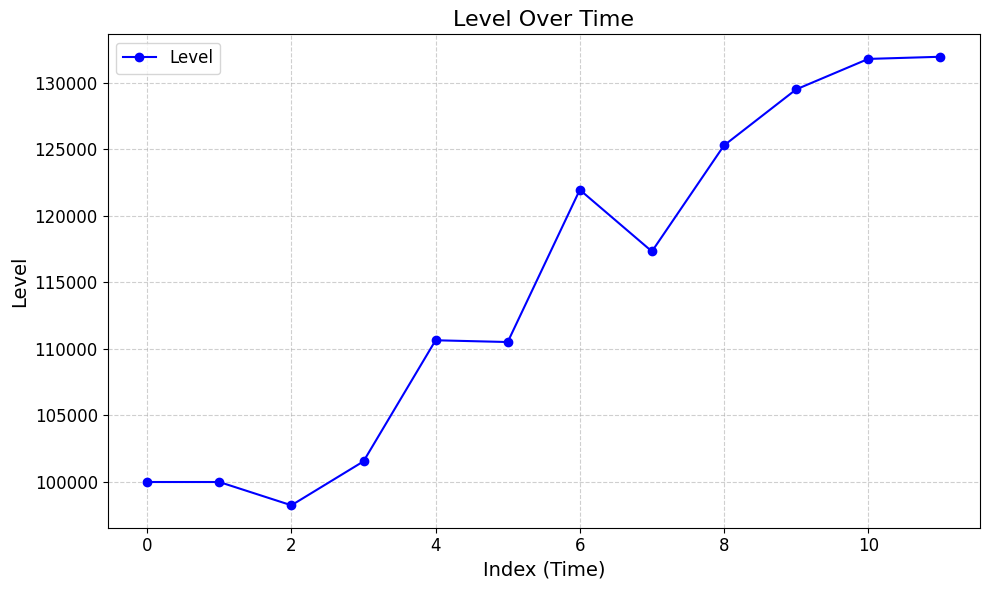

In [9]:
V.records["level"]

# Assuming V.records["level"] contains your data
plt.figure(figsize=(10, 6))

# Plotting the level column
plt.plot(V.records.index, V.records["level"], marker='o', linestyle='-', color='blue', label='Level')

# Adding labels, title, and legend
plt.title("Level Over Time", fontsize=16)
plt.xlabel("Index (Time)", fontsize=14)
plt.ylabel("Level", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
win_rate = 0.50
max_exposure = 0.10
buy_exposure = 0.05
loss_exposure = -0.05
max_return = 1.50
PT = 0.32
cash_min = 0.03
# Define the model container
m = Container()

# Sets


time_index = 12
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, 12, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, 12, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)

# Initial cash value
init_cash = 100000

# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")


## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["0"] + V[str(time_index-1)]) >= Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)








## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

win_loss1 = Equation(
    m,
    name="win_loss1",
    description="states the win loss ratio of the fund"
)
win_loss1[...] = (
    Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
)



win_loss2 = Equation(
    m,
    name="win_loss2",
    description="states the win loss ratio of the fund"
)
win_loss2[...] = (
    Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
)


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, (prices[stocks, time] * b[stocks, time])) + 
    Sum(stocks, (prices[stocks, time] * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == 100000
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]

### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]




## Objective function
obj_function = Equation(container=m, name="obj_function")
obj_function[...] = V["11"] == Z  # Maximize the portfolio value at time 11

# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MAX,
    objective=Z
)

# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1), solver_options={"reslim": "50"})


In [27]:
win_rate = 0.50
max_exposure = 0.10
buy_exposure = 0.05
loss_exposure = -0.05
max_return = 1.50
PT = 0.32
cash_min = 0.03
# Define the model container
m = Container()

# Sets


time_index = 12
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, 12, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, 12, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)

# Initial cash value
init_cash = 100000

# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")


## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["0"] + V[str(time_index-1)]) >= Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)








## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

win_loss1 = Equation(
    m,
    name="win_loss1",
    description="states the win loss ratio of the fund"
)
win_loss1[...] = (
    Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
)



win_loss2 = Equation(
    m,
    name="win_loss2",
    description="states the win loss ratio of the fund"
)
win_loss2[...] = (
    Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
)


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, (prices[stocks, time] * b[stocks, time])) + 
    Sum(stocks, (prices[stocks, time] * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == 100000
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]

### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]




## Objective function
obj_function = Equation(container=m, name="obj_function")
obj_function[...] = V["11"] == Z  # Maximize the portfolio value at time 11

# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MAX,
    objective=Z
)

# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1), solver_options={"reslim": "50"})


--- Job _845481d0-3b54-44c8-ac62-660a1ce12706.gms Start 11/25/24 19:44:08 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MIP CPLEX
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\_845481d0-3b54-44c8-ac62-660a1ce12706.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\_845481d0-3b54-44c8-ac62-660a1ce12706.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\tmpfgvk9ztk\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\_845481d0-3b54-44c8-ac62-660a1ce12706.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX C:\Users\SARANG~1\AppData\Local\Temp\tmpskz2ksx_\_845481d0-

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,Integer,134862.22153142,1300,1225,MIP,CPLEX,21.313


In [10]:
omega.records[omega.records['level'] >= 0.01]


,stocks,level,marginal,lower,upper,scale
0,XOM,1.0,NaN,0.0,1.0,1.0
2,BP,1.0,NaN,0.0,1.0,1.0
4,TTE,1.0,NaN,0.0,1.0,1.0
10,DVN,1.0,NaN,0.0,1.0,1.0
12,APA,1.0,NaN,0.0,1.0,1.0
15,SLB,1.0,NaN,0.0,1.0,1.0
18,NBR,1.0,NaN,0.0,1.0,1.0
20,EPD,1.0,NaN,0.0,1.0,1.0
21,ENB,1.0,NaN,0.0,1.0,1.0
22,KMI,1.0,NaN,0.0,1.0,1.0


In [11]:
omega_trades.records[omega_trades.records['level'] >= 0.01]

,stocks,level,marginal,lower,upper,scale
0,XOM,1.0,NaN,0.0,1.0,1.0
1,CVX,1.0,NaN,0.0,1.0,1.0
2,BP,1.0,NaN,0.0,1.0,1.0
3,SHEL,1.0,NaN,0.0,1.0,1.0
4,TTE,1.0,NaN,0.0,1.0,1.0
5,E,1.0,NaN,0.0,1.0,1.0
6,PBR,1.0,NaN,0.0,1.0,1.0
7,EQNR,1.0,NaN,0.0,1.0,1.0
8,COP,1.0,NaN,0.0,1.0,1.0
9,MRO,1.0,NaN,0.0,1.0,1.0


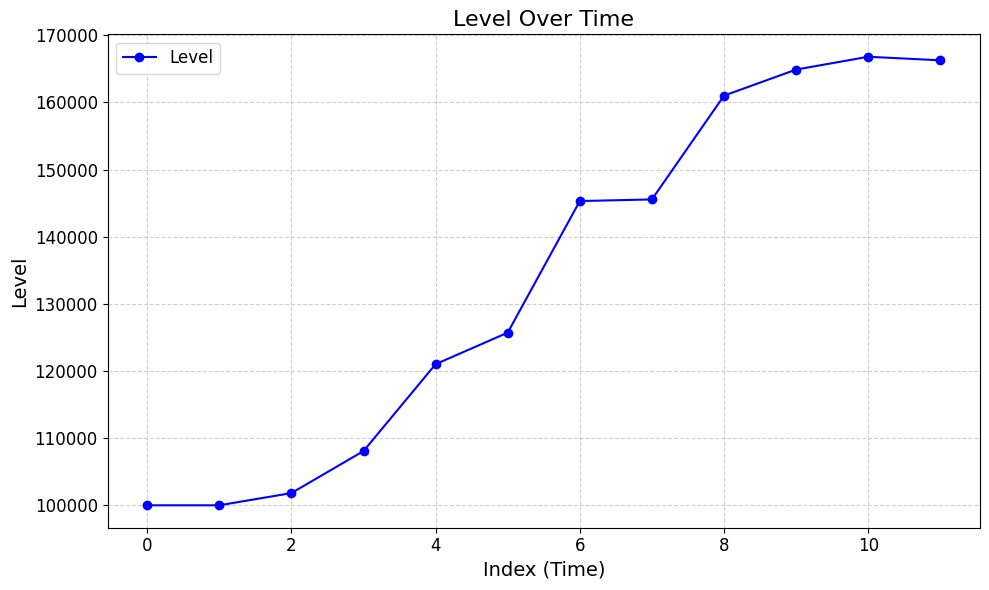

In [368]:
win_rate = 0.50
max_exposure = 0.15
buy_exposure = 0.10
loss_exposure = -0.05
max_return = 1.80
PT = 0.32
cash_min = 0.001


# Define the model container
m = Container()
expected_return = 1.47


# Sets


time_index = 12
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, 12, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, 12, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)

# Initial cash value
init_cash = 100000

# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")


## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["0"] + V[str(time_index-1)]) >= Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)








## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

# win_loss1 = Equation(
#     m,
#     name="win_loss1",
#     description="states the win loss ratio of the fund"
# )
# win_loss1[...] = (
#     Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
# )



# win_loss2 = Equation(
#     m,
#     name="win_loss2",
#     description="states the win loss ratio of the fund"
# )
# win_loss2[...] = (
#     Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
# )


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, (prices[stocks, time] * b[stocks, time])) + 
    Sum(stocks, (prices[stocks, time] * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == 100000
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]

### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus",type="Positive")

constraint_deviation = Equation(container=m, name="constraint_deviation")
constraint_deviation[...] = V["11"] - expected_return * init_cash + Sum(stocks, omega[stocks]) == Z_plus - Z_minus

obj_function = Equation(container=m, name="obj_function")
obj_function[...] = Z == Z_plus + Z_minus




# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=Z
)


gdx_path = m.gdxOutputPath()
# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1 ), solver_options={"reslim": "50", "SolnPoolReplace": 2, "SolnPoolPop": 2, " PopulateLim": 1000})


In [47]:
# Compute holding value
holding_value = prices.records.merge(x.records, on=['stocks', 'time'])
holding_value


,stocks,time,value,level,marginal,lower,upper,scale
0,MMM,0,126.939247,0.000000,-0.0,0.0,0.0,1.0
1,MMM,1,138.327179,36.146186,0.0,0.0,inf,1.0
2,MMM,2,129.442307,36.146186,0.0,0.0,inf,1.0
3,MMM,3,136.665619,36.146186,0.0,0.0,inf,1.0
4,MMM,4,144.774399,36.146186,0.0,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
355,AMT,7,424.377655,20.486209,0.0,0.0,inf,1.0
356,AMT,8,427.238678,20.486209,0.0,0.0,inf,1.0
357,AMT,9,448.128479,20.486209,0.0,0.0,inf,1.0
358,AMT,10,468.439026,20.486209,0.0,0.0,inf,1.0


In [48]:
holding_value['HoldingValue'] = holding_value['value'] * holding_value['level']
result = holding_value.merge(V.records, on='time')
result['NormalizedValue'] = result['HoldingValue'] / result['level_y']

In [49]:
result[['stocks', 'time', 'NormalizedValue']]

,stocks,time,NormalizedValue
0,MMM,0,0.000000
1,MMM,1,0.050000
2,MMM,2,0.046520
3,MMM,3,0.049132
4,MMM,4,0.051521
...,...,...,...
355,AMT,7,0.091997
356,AMT,8,0.088915
357,AMT,9,0.090595
358,AMT,10,0.092437


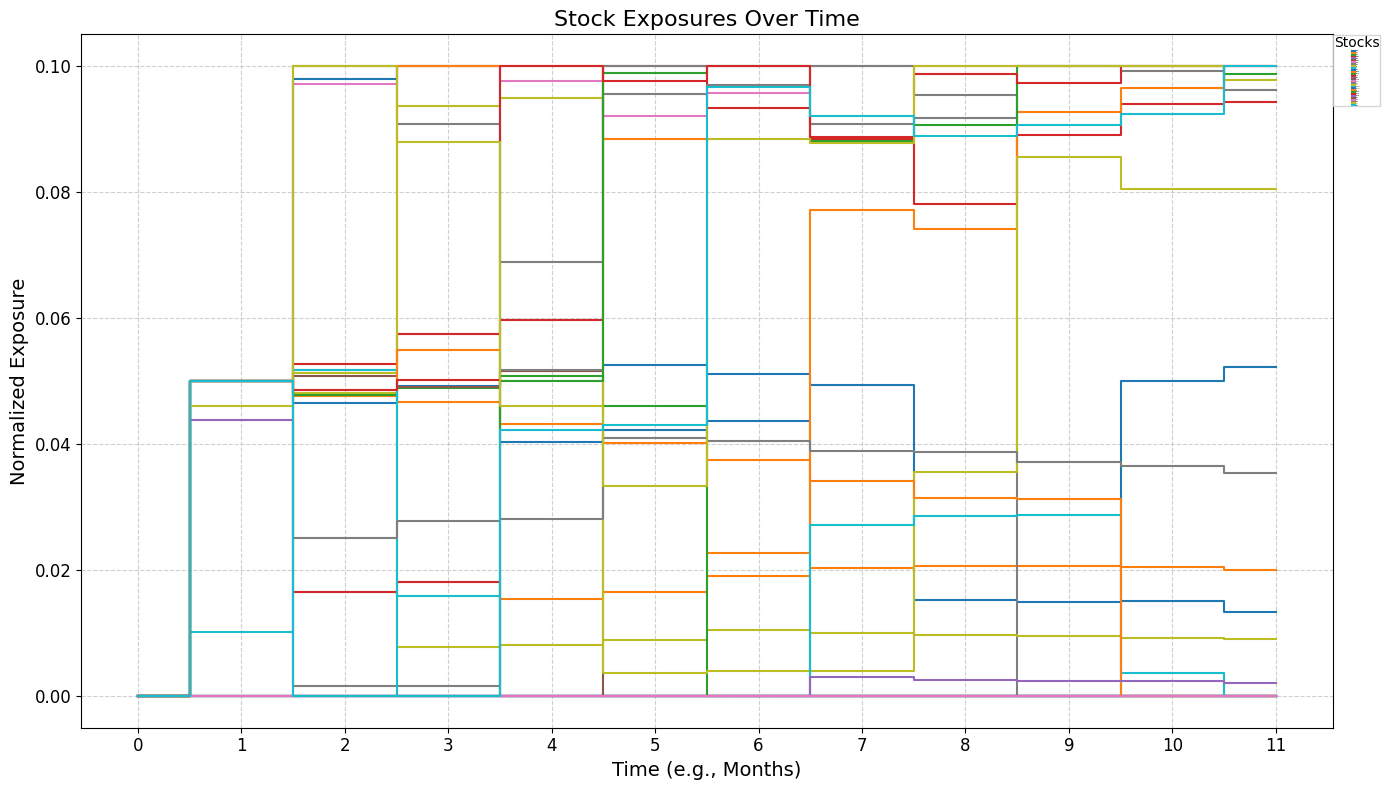

In [50]:
# Pivot the DataFrame to have stocks as columns
pivoted_df = result.pivot(index='time', columns='stocks', values='NormalizedValue')

# Plot the exposures for each stock over time
plt.figure(figsize=(14, 8))

for stock in pivoted_df.columns:
    plt.plot(
        pivoted_df.index, 
        pivoted_df[stock], 
        label=stock, 
        drawstyle="steps-mid"
    )

# Add labels, title, and legend
plt.title('Stock Exposures Over Time', fontsize=16)
plt.xlabel('Time (e.g., Months)', fontsize=14)
plt.ylabel('Normalized Exposure', fontsize=14)
plt.legend(title='Stocks', bbox_to_anchor=(1, 1), loc='upper left', fontsize=1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [51]:
positive_exposure = pivoted_df > 0.01
stocks_held_count = positive_exposure.sum(axis=1)
stocks_held_count

time
0      0
1     21
2     18
3     16
4     17
5     15
6     15
7     15
8     15
9     14
10    13
11    13
dtype: int64

In [52]:
omega.records

,stocks,level,marginal,lower,upper,scale
0,MMM,1.0,-0.0,0.0,1.0,1.0
1,AOS,1.0,-0.0,0.0,1.0,1.0
2,ABT,1.0,-0.0,0.0,1.0,1.0
3,ABBV,1.0,-0.0,0.0,1.0,1.0
4,ACN,1.0,-0.0,0.0,1.0,1.0
5,ADBE,1.0,-0.0,0.0,1.0,1.0
6,AMD,1.0,-0.0,0.0,1.0,1.0
7,AES,1.0,-0.0,0.0,1.0,1.0
8,AFL,1.0,-0.0,0.0,1.0,1.0
9,A,1.0,-0.0,0.0,1.0,1.0


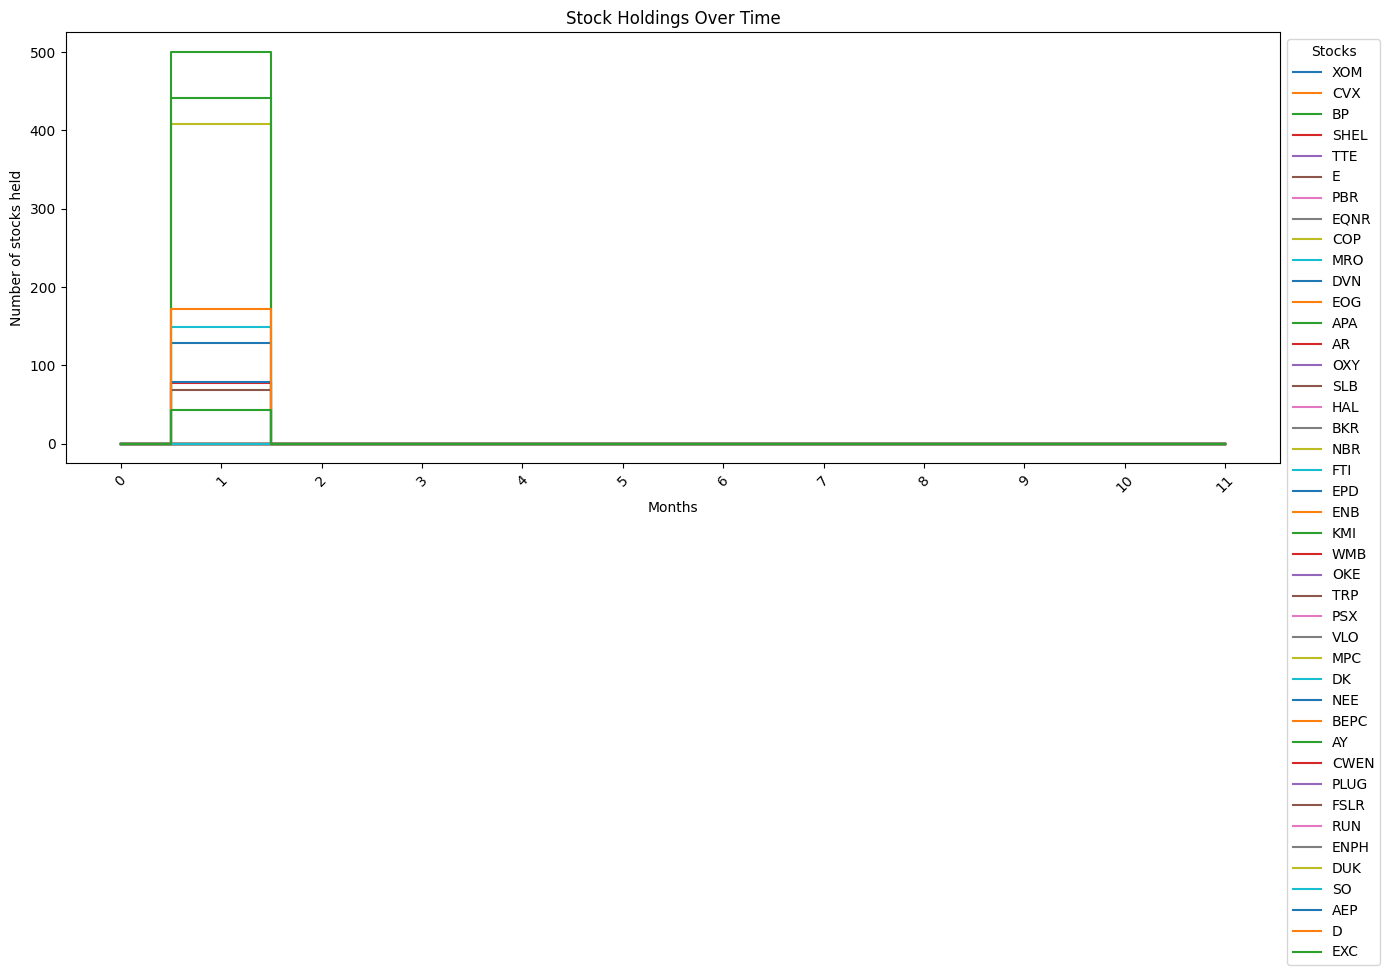

In [316]:

# Assuming x.records has columns 'stocks', 'time', and 'holdings'
# Pivot the DataFrame to get a 'time' vs 'stocks' structure for holdings
pivoted_df = b.records.pivot(index='time', columns='stocks', values='level')

# Plot the holdings for each stock over time
plt.figure(figsize=(14, 8))

# Plot each stock's holdings over time
for stock in pivoted_df.columns:
    plt.plot(pivoted_df.index, pivoted_df[stock], label=stock, drawstyle="steps-mid")

# Adding labels and title
plt.title('Stock Holdings Over Time')
plt.xlabel('Months')
plt.ylabel('Number of stocks held')
plt.legend(title='Stocks', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [190]:
# Count the number of 1s in the 'level' column
count_ones = omega.records['level'].sum()

# Print the result
print(f"Number of 1s in the 'level' column: {count_ones/len(stocks)}")


Number of 1s in the 'level' column: 0.558139534883279


In [67]:
def portfolio_optimization(win_rate=0.70, max_exposure=0.10, max_min=True):
    """
    Solves a portfolio optimization problem with constraints.
    
    Parameters:
        win_rate (float): The win rate threshold for determining successful investments.
        max_exposure (float): Maximum allowable exposure to a single stock as a fraction of NAV.
        max_min (bool): True for maximizing NAV, False for minimizing NAV.
    
    Returns:
        Solution: Optimized portfolio variables and objective value.
    """
    # Define the model container
    m = Container()

    # Sets
    time_index = 12
    stocks = Set(container=m, name="stocks", records=tickers)  # List of valid stock tickers
    time = Set(container=m, name="time", records=np.arange(0, time_index, 1))
    subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))

    # Parameters
    prices = Parameter(
        container=m,
        name="prices",
        domain=[stocks, time],
        records=prices_array,
    )

    init_cash = 100000

    # Variables
    C = Variable(container=m, name="C", domain=time, type="Positive")
    V = Variable(container=m, name="V", domain=time, type="Positive")
    x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
    x.fx[stocks, '0'] = 0
    b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")
    b.fx[stocks, '0'] = 0
    s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
    Z = Variable(container=m, name="Z", type="free")
    Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")
    Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")
    omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")

    # Equations
    total_sales = Equation(
        m,
        name="total_sales",
        domain=[stocks],
        description="Calculates total revenue from selling stock i"
    )
    total_sales[stocks] = (
        Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time])
    )

    total_purchases = Equation(
        m,
        name="total_purchases",
        domain=[stocks],
        description="Calculates total cost of buying stock i"
    )
    total_purchases[stocks] = (
        Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time])
    )

    eps = 0.00001
    M = 10000000

    winner_determination = Equation(
        m,
        name="winner_determination",
        domain=[stocks],
        description="Determines if stock i is a winner"
    )
    winner_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) >= Br[stocks] + eps * omega[stocks] - M * (1 - omega[stocks])
    )

    loser_determination = Equation(
        m,
        name="loser_determination",
        domain=[stocks],
        description="Determines if stock i is a loser"
    )
    loser_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) - Br[stocks] <= -eps * (1 - omega[stocks]) + M * omega[stocks]
    )

    win_loss = Equation(
        m,
        name="win_loss",
        description="Ensures win-loss ratio meets specified threshold"
    )
    win_loss[...] = (
        Sum(stocks, omega[stocks]) >= win_rate * len(tickers)
    )

    holdings_balance = Equation(
        m,
        name="holdings_balance",
        domain=[stocks, time],
        description="Tracks stock holdings over time"
    )
    holdings_balance[stocks, subtime] = (
        x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
    )

    holdings_balance_initial = Equation(
        m,
        name="holdings_balance_initial",
        domain=[stocks],
        description="Initial stock holdings"
    )
    holdings_balance_initial[stocks] = (
        x[stocks, "0"] == 0
    )

    cash_balance = Equation(
        m,
        name="cash_balance",
        domain=[time],
        description="Tracks cash balance over time"
    )
    cash_balance[time] = (
        C[time].where[subtime[time]] == C[time - 1] - Sum(stocks, (prices[stocks, time] * b[stocks, time])) + 
        Sum(stocks, (prices[stocks, time] * s[stocks, time]))
    )

    cash_balance_initial = Equation(
        m,
        name="cash_balance_initial",
        description="Initial cash balance"
    )
    cash_balance_initial[...] = (
        C["0"] == init_cash
    )

    nav = Equation(
        m,
        name="nav",
        domain=[time],
        description="Calculates NAV"
    )
    nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))

    risk_constraint = Equation(
        m,
        name="risk_constraint",
        domain=[stocks, time],
        description="Maintains risk constraints"
    )
    risk_constraint[stocks, time] = max_exposure * V[time] >= prices[stocks, time] * x[stocks, time]

    obj_function = Equation(container=m, name="obj_function")
    
    obj_function[...] = V["11"] == Z  
    

    if max_min:
        obj_dir = Sense.MAX
    else:
        obj_dir = Sense.MIN
    # Model definition
    model = Model(
        container=m,
        name="portfolio_optimization",
        equations=m.getEquations(),
        problem="MIP",
        sense=obj_dir,
        objective=Z
    )

    # Solve the model
    solution = model.solve(solver="CPLEX", options=Options(report_solution=1), solver_options={"reslim": "10"})
    
    return solution

In [68]:
bruh = portfolio_optimization(win_rate=0.70, max_exposure=0.10, max_min=False)

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


In [69]:
bruh

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,42779.9184193714,1231,1702,MIP,CPLEX,10.031


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-44.9559549752582


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-55.277235345930094
-62.051368281239895
-66.60409291762231
-69.7885461068514


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-42.6986385054807


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-53.510501513299204


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-60.8732075880552
-65.87943761111289
-69.3873617888881


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-39.7431374062033


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-50.48020247831659


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-58.48081960885151


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-64.294963644044
-68.3831174133403


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-35.0172318124


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-45.626009484312306


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-53.8103495466284


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


-60.307335719750895
-65.36807228405391


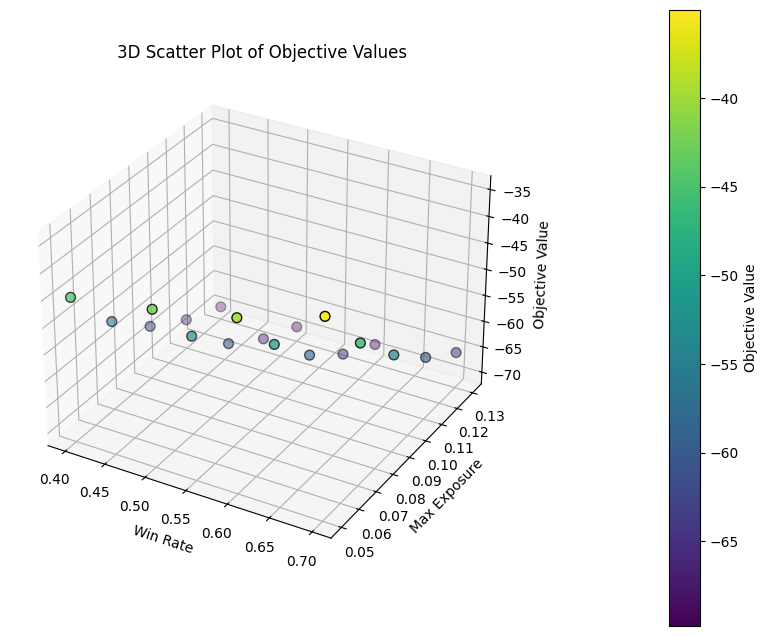

In [70]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define ranges for win_rate and max_exposure
win_rate_values = np.arange(0.40, 0.80, 0.10)  # From 0.30 to 0.70 inclusive
max_exposure_values = np.arange(0.05, 0.15, 0.02)  # From 0.05 to 0.15 inclusive




# Collect results
results = []
for win_rate in win_rate_values:
    for max_exposure in max_exposure_values:
        result = portfolio_optimization(win_rate=win_rate, max_exposure=max_exposure, max_min=False)
        drawdown = ((init_cash - float(result['Objective'].iloc[0])) / init_cash) * -100
        print(drawdown)
        results.append(pd.DataFrame({"win_rate": [win_rate], "max_exposure": [max_exposure], "objective":[drawdown] }))

# Combine all results into a single DataFrame
df = pd.concat(results, ignore_index=True)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df['win_rate'], df['max_exposure'], df['objective'],
    c=df['objective'], cmap='viridis', s=50, edgecolor='k'
)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.2)
cbar.set_label('Objective Value')

# Set labels
ax.set_xlabel('Win Rate')
ax.set_ylabel('Max Exposure')
ax.set_zlabel('Objective Value')

# Set title
ax.set_title('3D Scatter Plot of Objective Values')

# Show plot
plt.show()

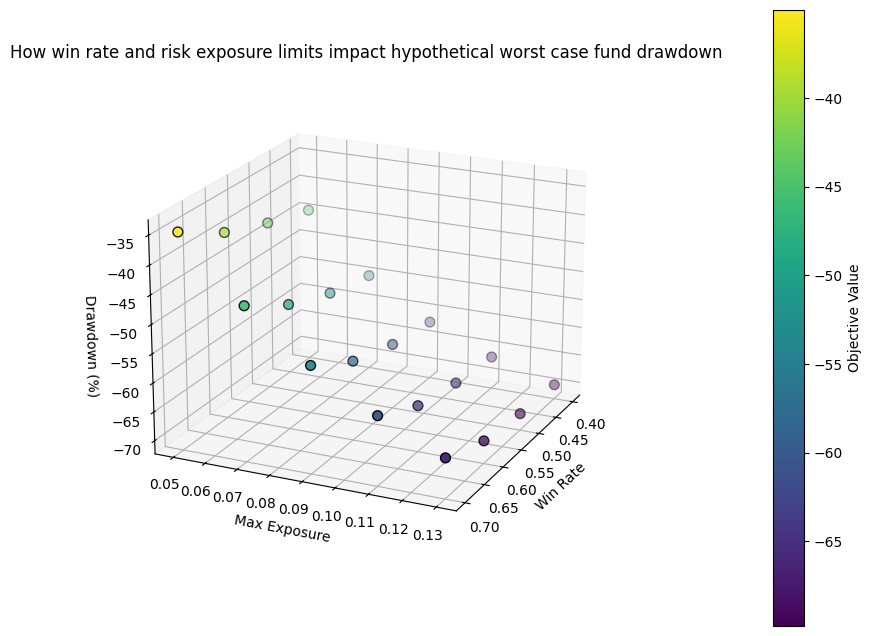

In [71]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df['win_rate'], df['max_exposure'], df['objective'],
    c=df['objective'], cmap='viridis', s=50, edgecolor='k'
)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.2)
cbar.set_label('Objective Value')

# Set labels
ax.set_xlabel('Win Rate')
ax.set_ylabel('Max Exposure')
ax.set_zlabel('Drawdown (%)')

# Set title
ax.set_title('How win rate and risk exposure limits impact hypothetical worst case fund drawdown')

# Set a custom view angle
ax.view_init(elev=20, azim=25)  # Adjust angles as needed

# Show plot
plt.show()


In [34]:

# Define ranges for win_rate and max_exposure
win_rate_values = np.arange(0.10, 0.80, 0.10)  # From 0.30 to 0.70 inclusive
max_exposure_values = np.arange(0.05, 0.15, 0.01)  # From 0.05 to 0.15 inclusive




# Collect results
results = []
for win_rate in win_rate_values:
    for max_exposure in max_exposure_values:
        result = portfolio_optimization(win_rate=win_rate, max_exposure=max_exposure, max_min=True)
        drawdown = ((init_cash - float(result['Objective'])) / init_cash) * -100

        results.append(pd.DataFrame({"win_rate": [win_rate], "max_exposure": [max_exposure], "objective":[drawdown] }))

# Combine all results into a single DataFrame
df = pd.concat(results, ignore_index=True)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df['win_rate'], df['max_exposure'], df['objective'],
    c=df['objective'], cmap='viridis', s=50, edgecolor='k'
)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.2)
cbar.set_label('Objective Value')

# Set labels
ax.set_xlabel('Win Rate')
ax.set_ylabel('Max Exposure')
ax.set_zlabel('Objective Value')

# Set title
ax.set_title('3D Scatter Plot of Objective Values')

# Show plot
plt.show()

C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_30628\3919822494.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drawdown = ((init_cash - float(result['Objective'])) / init_cash) * -100
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_30628\3919822494.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drawdown = ((init_cash - float(result['Objective'])) / init_cash) * -100
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_30628\3919822494.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drawdown = ((init_cash - float(result['Objective'])) / init_cash) * -100
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_30628\3919822494.py:13: FutureWarning: Calling float on a single eleme

GamspyException: Solve status: SystemError. This indicates a completely unknown or unexpected error condition.

=============
Error Summary
=============

**** SOLVER STATUS     13 System Failure
**** MODEL STATUS      13 Error No Solution
**** OBJECTIVE VALUE               NA

 RESOURCE USAGE, LIMIT         NA     10000000000.000
 ITERATION COUNT, LIMIT        NA    2147483647
--- GAMS/CPLEX licensed for continuous and discrete problems.

In [43]:
# Revised function for the updated model
def revised_model_max(win_rate, max_exposure, buy_exposure, max_return, PT, init_cash):
    # Define the model container
    m = Container()

    # Sets
    time_index = 12
    stocks = Set(container=m, name="stocks", records=tickers)  # Set of stocks
    time = Set(container=m, name="time", records=np.arange(0, time_index, 1))  # Set of time periods
    subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))  # Subset excluding the last time

    # Parameters
    prices = Parameter(
        container=m,
        name="prices",
        domain=[stocks, time],
        records=prices_array,
    )

    # Variables
    C = Variable(container=m, name="C", domain=time, type="Positive")  # Cash balance
    V = Variable(container=m, name="V", domain=time, type="Positive")  # Portfolio NAV
    x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")  # Stock holdings
    b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")  # Stock purchases
    s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")  # Stock sales
    Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")  # Total sales of stock
    Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")  # Total purchases of stock
    omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")  # Binary for winners
    Z = Variable(container=m, name="Z", type="free")  # Objective variable

    # Equation declarations
    total_sales = Equation(m, name="total_sales", domain=[stocks])
    portfolio_turnover = Equation(m, name="portfolio_turnover")
    total_purchases = Equation(m, name="total_purchases", domain=[stocks])
    winner_determination = Equation(m, name="winner_determination", domain=[stocks])
    loser_determination = Equation(m, name="loser_determination", domain=[stocks])
    max_returns = Equation(m, name="max_returns", domain=[stocks])
    win_loss1 = Equation(m, name="win_loss1")
    win_loss2 = Equation(m, name="win_loss2")
    holdings_balance = Equation(m, name="holdings_balance", domain=[stocks, time])
    holdings_balance_initial = Equation(m, name="holdings_balance_initial", domain=[stocks])
    cash_balance = Equation(m, name="cash_balance", domain=[time])
    cash_balance_initial = Equation(m, name="cash_balance_initial")
    nav = Equation(m, name="nav", domain=[time])
    risk_constraint = Equation(m, name="risk_constraint", domain=[stocks, time])
    buy_risk_constraint = Equation(m, name="buy_risk_constraint", domain=[stocks, time])
    obj_function = Equation(container=m, name="obj_function")

    # Equation assignments
    total_sales[stocks] = Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time])

    portfolio_turnover[...] = (
        PT * (V["0"] + V[str(time_index - 1)]) == Sum(stocks, Sum(time, b[stocks, time] * prices[stocks, time])) * 2
    )

    total_purchases[stocks] = Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time])

    eps = 0.00001
    M = 10000000

    winner_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        >= Br[stocks] + eps * omega[stocks] - M * (1 - omega[stocks])
    )

    loser_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        - Br[stocks]
        <= -eps * (1 - omega[stocks]) + M * omega[stocks]
    )

    max_returns[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        <= Br[stocks] * max_return
    )

    win_loss1[...] = Sum(stocks, omega[stocks]) >= (0.98 * win_rate) * len(tickers)

    win_loss2[...] = Sum(stocks, omega[stocks]) <= (1.02 * win_rate) * len(tickers)

    holdings_balance[stocks, subtime] = (
        x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
    )

    holdings_balance_initial[stocks] = x[stocks, "0"] == 0

    cash_balance[time] = (
        C[time].where[subtime[time]]
        == C[time - 1]
        - Sum(stocks, (prices[stocks, time] * b[stocks, time]))
        + Sum(stocks, (prices[stocks, time] * s[stocks, time]))
    )

    cash_balance_initial[...] = C["0"] == init_cash

    nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))

    risk_constraint[stocks, time] = max_exposure * V[time] >= prices[stocks, time] * x[stocks, time]

    buy_risk_constraint[stocks, time] = buy_exposure * V[time] >= prices[stocks, time] * b[stocks, time]

    obj_function[...] = V["11"] == Z  # Maximize portfolio value at the end

    # Model definition
    b1 = Model(
        container=m,
        name="b1",
        equations=m.getEquations(),
        problem="MIP",
        sense=Sense.MAX,
        objective=Z,
    )

    # Solve the model
    solution = b1.solve(options=Options(report_solution=1), solver_options={"reslim": "20"})
    return solution['Objective']

In [44]:
# Revised function for the updated model
def revised_model_min(win_rate, max_exposure, buy_exposure, max_return, PT, init_cash):
    # Define the model container
    m = Container()

    # Sets
    time_index = 12
    stocks = Set(container=m, name="stocks", records=tickers)  # Set of stocks
    time = Set(container=m, name="time", records=np.arange(0, time_index, 1))  # Set of time periods
    subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))  # Subset excluding the last time

    # Parameters
    prices = Parameter(
        container=m,
        name="prices",
        domain=[stocks, time],
        records=prices_array,
    )

    # Variables
    C = Variable(container=m, name="C", domain=time, type="Positive")  # Cash balance
    V = Variable(container=m, name="V", domain=time, type="Positive")  # Portfolio NAV
    x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")  # Stock holdings
    b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")  # Stock purchases
    s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")  # Stock sales
    Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")  # Total sales of stock
    Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")  # Total purchases of stock
    omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")  # Binary for winners
    Z = Variable(container=m, name="Z", type="free")  # Objective variable

    # Equation declarations
    total_sales = Equation(m, name="total_sales", domain=[stocks])
    portfolio_turnover = Equation(m, name="portfolio_turnover")
    total_purchases = Equation(m, name="total_purchases", domain=[stocks])
    winner_determination = Equation(m, name="winner_determination", domain=[stocks])
    loser_determination = Equation(m, name="loser_determination", domain=[stocks])
    max_returns = Equation(m, name="max_returns", domain=[stocks])
    win_loss1 = Equation(m, name="win_loss1")
    win_loss2 = Equation(m, name="win_loss2")
    holdings_balance = Equation(m, name="holdings_balance", domain=[stocks, time])
    holdings_balance_initial = Equation(m, name="holdings_balance_initial", domain=[stocks])
    cash_balance = Equation(m, name="cash_balance", domain=[time])
    cash_balance_initial = Equation(m, name="cash_balance_initial")
    nav = Equation(m, name="nav", domain=[time])
    risk_constraint = Equation(m, name="risk_constraint", domain=[stocks, time])
    buy_risk_constraint = Equation(m, name="buy_risk_constraint", domain=[stocks, time])
    obj_function = Equation(container=m, name="obj_function")

    # Equation assignments
    total_sales[stocks] = Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time])

    portfolio_turnover[...] = (
        PT * (V["0"] + V[str(time_index - 1)]) == Sum(stocks, Sum(time, b[stocks, time] * prices[stocks, time])) * 2
    )

    total_purchases[stocks] = Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time])

    eps = 0.00001
    M = 10000000

    winner_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        >= Br[stocks] + eps * omega[stocks] - M * (1 - omega[stocks])
    )

    loser_determination[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        - Br[stocks]
        <= -eps * (1 - omega[stocks]) + M * omega[stocks]
    )

    max_returns[stocks] = (
        (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)])
        <= Br[stocks] * max_return
    )

    win_loss1[...] = Sum(stocks, omega[stocks]) >= (0.98 * win_rate) * len(tickers)

    win_loss2[...] = Sum(stocks, omega[stocks]) <= (1.02 * win_rate) * len(tickers)

    holdings_balance[stocks, subtime] = (
        x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
    )

    holdings_balance_initial[stocks] = x[stocks, "0"] == 0

    cash_balance[time] = (
        C[time].where[subtime[time]]
        == C[time - 1]
        - Sum(stocks, (prices[stocks, time] * b[stocks, time]))
        + Sum(stocks, (prices[stocks, time] * s[stocks, time]))
    )

    cash_balance_initial[...] = C["0"] == init_cash

    nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))

    risk_constraint[stocks, time] = max_exposure * V[time] >= prices[stocks, time] * x[stocks, time]

    buy_risk_constraint[stocks, time] = buy_exposure * V[time] >= prices[stocks, time] * b[stocks, time]

    obj_function[...] = V["11"] == Z  # Maximize portfolio value at the end

    # Model definition
    b1 = Model(
        container=m,
        name="b1",
        equations=m.getEquations(),
        problem="MIP",
        sense=Sense.MIN,
        objective=Z,
    )

    # Solve the model
    solution = b1.solve(options=Options(report_solution=1), solver_options={"reslim": "20"})
    return solution['Objective']

In [70]:
bruh = revised_model_max(win_rate=0.70, max_exposure=0.15, buy_exposure=0.10, max_return=1.50, PT=0.50, init_cash=100000)
print(bruh)
bruh = revised_model_min(win_rate=0.70, max_exposure=0.15, buy_exposure=0.10, max_return=1.50, PT=0.50, init_cash=100000)
print(bruh)

0    128571.428348571
Name: Objective, dtype: object
0    78055.6102359772
Name: Objective, dtype: object


In [73]:
bruh = revised_model_max(win_rate=0.80, max_exposure=0.15, buy_exposure=0.10, max_return=1.50, PT=0.30, init_cash=100000)
print(bruh)
bruh = revised_model_min(win_rate=0.80, max_exposure=0.15, buy_exposure=0.10, max_return=1.50, PT=0.30, init_cash=100000)
print(bruh)

0    116216.216216216
Name: Objective, dtype: object
0    85260.8538910174
Name: Objective, dtype: object


In [62]:
bruh

0    78055.6102359772
Name: Objective, dtype: object

In [41]:
100000-78055

21945

TypeError: unhashable type: 'numpy.ndarray'

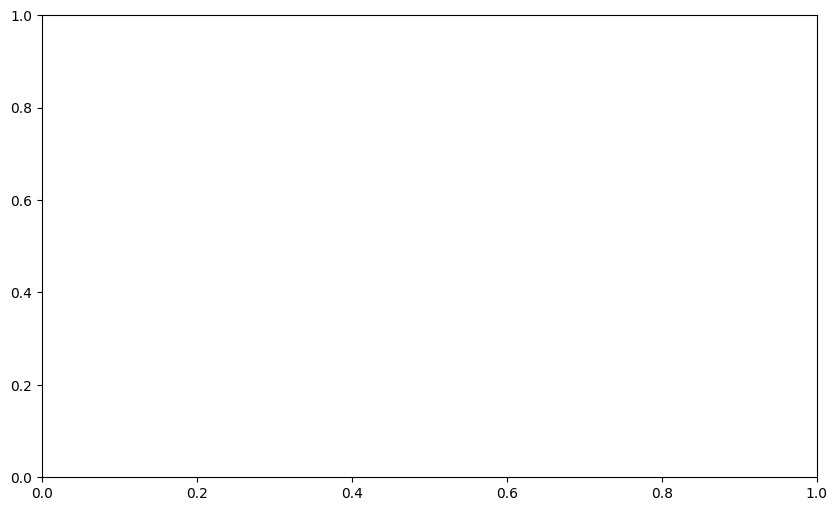

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for win_rate
win_rate_values = np.arange(0.40, 0.80, 0.10)  # From 0.40 to 0.70 inclusive

# Initialize lists to store results
min_objectives = []
max_objectives = []

# Iterate over win_rate values
for win_rate in win_rate_values:
    # Call the model functions to get min and max objective values
    min_result = revised_model_min(win_rate=win_rate, max_exposure=0.15, 
                                   buy_exposure=0.10, max_return=1.50, PT=0.50, init_cash=100000)
    max_result = revised_model_max(win_rate=win_rate, max_exposure=0.15, 
                                   buy_exposure=0.10, max_return=1.50, PT=0.50, init_cash=100000)
    
    # Append the results to respective lists
    min_objectives.append(min_result)
    max_objectives.append(max_result)

# Create a 2D plot
plt.figure(figsize=(10, 6))

# Plot min objectives
plt.plot(win_rate_values, min_objectives, label='Min Objective', marker='o', color='b', linewidth=2)

# Plot max objectives
plt.plot(win_rate_values, max_objectives, label='Max Objective', marker='o', color='r', linewidth=2)

# Add labels and title
plt.xlabel('Win Rate', fontsize=14)
plt.ylabel('Objective Value', fontsize=14)
plt.title('Min and Max Objective Values for Different Win Rates', fontsize=16)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [54]:
np.array(max_objectives)

array([['128571.428137143'],
       ['NA'],
       ['128571.428285714'],
       ['128571.428348571']], dtype=object)